# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import datetime as dt
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [2]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Loading & Cleaning

In [3]:
df = pd.read_csv('ulasan_film_indonesia.csv')

df.head()

,film,pengguna,ulasan,rating
0,Laskar Pelangi,Anonim,I love this so much,4.5 stars
1,Laskar Pelangi,Anonim,Ma kinda childhood movie 🌻,4.0 stars
2,Laskar Pelangi,Anonim,"This movie is just beautiful, touching, inspir...",4.5 stars
3,Laskar Pelangi,Anonim,read the book & watched this in middle school ...,3.0 stars
4,Laskar Pelangi,Anonim,Film legendaris Indonesia yang sangat jelas di...,4.5 stars


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15448 entries, 0 to 15447
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   film      15448 non-null  object
 1   pengguna  15448 non-null  object
 2   ulasan    15447 non-null  object
 3   rating    15448 non-null  object
dtypes: object(4)
memory usage: 482.9+ KB


In [5]:
df.describe(include='all')


,film,pengguna,ulasan,rating
count,15448,15448,15447,15448
unique,10,1,15244,11
top,Pengabdi Setan,Anonim,dan tadi saya melihat film ini dilan itu sebua...,4.0 stars
freq,2400,15448,14,3415


In [6]:
df.isna().sum()


,0
film,0
pengguna,0
ulasan,1
rating,0


In [7]:
df = df.dropna(subset=['ulasan'])


In [8]:
df.duplicated().sum()


np.int64(65)

In [9]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [10]:
df['rating'].unique()

array(['4.5 stars', '4.0 stars', '3.0 stars', '5.0 stars',
       'Tidak ada rating', '3.5 stars', '2.5 stars', '2.0 stars',
       '1.5 stars', '1.0 stars', '0.5 stars'], dtype=object)

In [11]:
def convert_rating(rating_str):
    if rating_str == 'Tidak ada rating':
        return np.nan
    score = rating_str[0:3]
    return score

df['numeric_rating'] = df['rating'].apply(convert_rating)
df['numeric_rating'] = pd.to_numeric(df['numeric_rating'], errors='coerce')
df['numeric_rating'] = df['numeric_rating'].fillna(df['numeric_rating'].median())

In [12]:
df.describe()


,numeric_rating
count,15382.000000
mean,3.492361
std,1.107036
min,0.500000
25%,3.000000
50%,3.500000
75%,4.000000
max,5.000000


In [13]:
df.head()

,film,pengguna,ulasan,rating,numeric_rating
0,Laskar Pelangi,Anonim,I love this so much,4.5 stars,4.5
1,Laskar Pelangi,Anonim,Ma kinda childhood movie 🌻,4.0 stars,4.0
2,Laskar Pelangi,Anonim,"This movie is just beautiful, touching, inspir...",4.5 stars,4.5
3,Laskar Pelangi,Anonim,read the book & watched this in middle school ...,3.0 stars,3.0
4,Laskar Pelangi,Anonim,Film legendaris Indonesia yang sangat jelas di...,4.5 stars,4.5


# Text Preprocessing

In [14]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin", "u": "you", "ur": "your", "r": "are", "ya": "you", "im": "i am", "ive": "i have", "idk": "i don't know", "lol": "laughing out loud", "omg": "oh my god", "wtf": "what the fuck", "wth": "what the hell", "btw": "by the way", "brb": "be right back", "bbl": "be back later", "ttyl": "talk to you later", "bff": "best friend forever", "tbh": "to be honest", "ikr": "i know right", "lmao": "laughing my ass off", "rofl": "rolling on the floor laughing", "smh": "shaking my head", "fyi": "for your information", "omfg": "oh my freaking god", "bday": "birthday", "thx": "thanks", "ty": "thank you", "np": "no problem", "cuz": "because", "bc": "because", "tho": "though", "ya'll": "you all", "lemme": "let me", "gonna": "going to", "wanna": "want to", "gotta": "got to", "ain't": "is not", "dont": "do not", "cant": "cannot", "couldnt": "could not", "wouldnt": "would not", "shouldnt": "should not", "ain’t": "is not", "nah": "no", "yea": "yeah", "alr": "already", "idc": "i don't care", "nope": "no", "ok": "okay", "k": "okay", "bro": "brother", "sis": "sister", "luv": "love", "hbd": "happy birthday", "ttys": "talk to you soon", "gr8": "great", "2day": "today", "b4": "before", "l8r": "later", "2moro": "tomorrow", "sup": "what's up", "yo": "hello", "oml": "oh my lord", "hmu": "hit me up", "jk": "just kidding", "nvm": "never mind", "atm": "at the moment", "afk": "away from keyboard", "gg": "good game", "gl": "good luck", "hf": "have fun", "irl": "in real life", "rn": "right now", "tf": "the fuck", "tmi": "too much information", "wyd": "what are you doing", "bruh": "bro", "fr": "for real", "cap": "lie", "no cap": "no lie", "bet": "okay", "slay": "do well", "fire": "awesome", "lit": "exciting", "sus": "suspicious", "flex": "show off", "vibe": "atmosphere", "stan": "support", "simp": "overly obsessed", "salty": "bitter", "lowkey": "slightly", "highkey": "definitely", "dead": "laughing hard", "mood": "relatable feeling", "fam": "close friend", "goat": "greatest of all time", "yeet": "throw", "snatched": "stylish", "bussin": "delicious", "fax": "true", "based": "authentic", "ratio": "disagree", "bop": "good song", "cringe": "awkward", "dragged": "criticized", "w": "win", "l": "loss", "mid": "average", "pog": "amazing", "poggers": "awesome", "karen": "entitled woman", "boomer": "old person", "fomo": "fear of missing out", "jomo": "joy of missing out", "ftw": "for the win", "dm": "direct message", "clapback": "witty response", "ghosted": "ignored", "shade": "indirect insult", "cancelled": "boycotted", "drag": "criticize", "thirsty": "desperate", "spill": "reveal", "tea": "gossip", "hot take": "controversial opinion", "ok boomer": "dismissive phrase", "on fleek": "perfect", "woke": "socially aware", "hella": "very", "sksksk": "laughter", "and i oop": "surprise", "periodt": "end of discussion", "yass": "yes", "af": "as fuck", "tfw": "that feeling when", "idgaf": "i don't give a fuck", "tldr": "too long didn't read", "ily": "i love you", "ilysm": "i love you so much", "omw": "on my way", "wbu": "what about you", "gm": "good morning", "gn": "good night", "gtg": "got to go", "ily2": "i love you too", "bffl": "best friends for life"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [15]:
lemmatizer = WordNetLemmatizer()

def cleaningText(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
  text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
  text = re.sub(r'RT[\s]', '', text) # remove RT
  text = re.sub(r"http\S+", '', text) # remove link
  text = re.sub(r'[0-9]+', '', text) # remove numbers
  text = re.sub(r'[^\w\s]', '', text) # remove numbers


  text = text.replace('\n', ' ') # replace new line into space
  text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
  text = text.strip(' ') # remove characters space from both left and right text
  return text

def casefoldingText(text): # Converting all the characters in a text into lower case
  text = text.lower()
  return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
  text = word_tokenize(text)
  return text

def removeStopwordTextIndo(text): # Removing stopwords from a list of tokens
  stop_words = set(stopwords.words("indonesian"))
  text = [word for word in text if word not in stop_words]
  return text

def removeStopwordTextEng(text): # Removing stopwords from a list of tokens
  stop_words = set(stopwords.words("english"))
  text = [word for word in text if word not in stop_words]
  return text

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [16]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['ulasan'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(removeStopwordTextIndo)
df['text_stopword'] = df['text_stopword'].apply(removeStopwordTextEng)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_stopword'].apply(toSentence)

In [17]:
df = df[df['text_akhir'].str.split().apply(len) > 3]

In [18]:
df.head()


,film,pengguna,ulasan,rating,numeric_rating,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
2,Laskar Pelangi,Anonim,"This movie is just beautiful, touching, inspir...",4.5 stars,4.5,This movie is just beautiful touching inspirin...,this movie is just beautiful touching inspirin...,this movie is just beautiful touching inspirin...,"[this, movie, is, just, beautiful, touching, i...","[movie, beautiful, touching, inspiring, heartw...",movie beautiful touching inspiring heartwarmin...
3,Laskar Pelangi,Anonim,read the book & watched this in middle school ...,3.0 stars,3.0,read the book watched this in middle school a...,read the book watched this in middle school a...,read the book watched this in middle school an...,"[read, the, book, watched, this, in, middle, s...","[read, book, watched, middle, school, pretty, ...",read book watched middle school pretty wholesome
4,Laskar Pelangi,Anonim,Film legendaris Indonesia yang sangat jelas di...,4.5 stars,4.5,Film legendaris Indonesia yang sangat jelas di...,film legendaris indonesia yang sangat jelas di...,film legendaris indonesia yang sangat jelas di...,"[film, legendaris, indonesia, yang, sangat, je...","[film, legendaris, indonesia, sepenuh, hati, b...",film legendaris indonesia sepenuh hati benarbe...
5,Laskar Pelangi,Anonim,Instead of slamming the door like any other sp...,4.5 stars,4.5,Instead of slamming the door like any other sp...,instead of slamming the door like any other sp...,instead of slamming the door like any other sp...,"[instead, of, slamming, the, door, like, any, ...","[instead, slamming, door, like, spoiled, teena...",instead slamming door like spoiled teenage gir...
6,Laskar Pelangi,Anonim,Film anak-anak yang mengandung banyak sekali p...,4.5 stars,4.5,Film anakanak yang mengandung banyak sekali pe...,film anakanak yang mengandung banyak sekali pe...,film anakanak yang mengandung banyak sekali pe...,"[film, anakanak, yang, mengandung, banyak, sek...","[film, anakanak, mengandung, pesan, moral, nil...",film anakanak mengandung pesan moral nilainila...


# Labelling

In [19]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [20]:
sia = SentimentIntensityAnalyzer()

text = df['text_akhir'].tolist()
scores = []
for i in text:
    score = sia.polarity_scores(i)
    scores.append(score)

def label_sentiment(score):
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_score'] = scores
df['sentiment_label'] = df['sentiment_score'].apply(label_sentiment)

In [21]:
df.head()


,film,pengguna,ulasan,rating,numeric_rating,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,sentiment_score,sentiment_label
2,Laskar Pelangi,Anonim,"This movie is just beautiful, touching, inspir...",4.5 stars,4.5,This movie is just beautiful touching inspirin...,this movie is just beautiful touching inspirin...,this movie is just beautiful touching inspirin...,"[this, movie, is, just, beautiful, touching, i...","[movie, beautiful, touching, inspiring, heartw...",movie beautiful touching inspiring heartwarmin...,"{'neg': 0.0, 'neu': 0.366, 'pos': 0.634, 'comp...",positive
3,Laskar Pelangi,Anonim,read the book & watched this in middle school ...,3.0 stars,3.0,read the book watched this in middle school a...,read the book watched this in middle school a...,read the book watched this in middle school an...,"[read, the, book, watched, this, in, middle, s...","[read, book, watched, middle, school, pretty, ...",read book watched middle school pretty wholesome,"{'neg': 0.0, 'neu': 0.652, 'pos': 0.348, 'comp...",positive
4,Laskar Pelangi,Anonim,Film legendaris Indonesia yang sangat jelas di...,4.5 stars,4.5,Film legendaris Indonesia yang sangat jelas di...,film legendaris indonesia yang sangat jelas di...,film legendaris indonesia yang sangat jelas di...,"[film, legendaris, indonesia, yang, sangat, je...","[film, legendaris, indonesia, sepenuh, hati, b...",film legendaris indonesia sepenuh hati benarbe...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
5,Laskar Pelangi,Anonim,Instead of slamming the door like any other sp...,4.5 stars,4.5,Instead of slamming the door like any other sp...,instead of slamming the door like any other sp...,instead of slamming the door like any other sp...,"[instead, of, slamming, the, door, like, any, ...","[instead, slamming, door, like, spoiled, teena...",instead slamming door like spoiled teenage gir...,"{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp...",positive
6,Laskar Pelangi,Anonim,Film anak-anak yang mengandung banyak sekali p...,4.5 stars,4.5,Film anakanak yang mengandung banyak sekali pe...,film anakanak yang mengandung banyak sekali pe...,film anakanak yang mengandung banyak sekali pe...,"[film, anakanak, yang, mengandung, banyak, sek...","[film, anakanak, mengandung, pesan, moral, nil...",film anakanak mengandung pesan moral nilainila...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral


# Data Exploration

In [22]:
df['sentiment_label'].value_counts()

,count
sentiment_label,
positive,5620
neutral,3705
negative,2840


In [23]:
print("Laskar Pelangi", df[df['film'] == 'Laskar Pelangi']['sentiment_label'].value_counts())
print("Sang Pemimpi", df[df['film'] == 'Sang Pemimpi']['sentiment_label'].value_counts())
print("The Raid: Redemption", df[df['film'] == 'The Raid: Redemption']['sentiment_label'].value_counts())
print("Habibie & Ainun", df[df['film'] == 'Habibie & Ainun']['sentiment_label'].value_counts())
print("Pengabdi Setan", df[df['film'] == 'Pengabdi Setan']['sentiment_label'].value_counts())
print("Dilan 1990", df[df['film'] == 'Dilan 1990']['sentiment_label'].value_counts())
print("5cm", df[df['film'] == '5cm']['sentiment_label'].value_counts())
print("KKN di Desa Penari", df[df['film'] == 'KKN di Desa Penari']['sentiment_label'].value_counts())
print("Gundala", df[df['film'] == 'Gundala']['sentiment_label'].value_counts())
print("Mencuri Raden Saleh", df[df['film'] == 'Mencuri Raden Saleh']['sentiment_label'].value_counts())

Laskar Pelangi sentiment_label
positive    236
neutral     225
negative     44
Name: count, dtype: int64
Sang Pemimpi sentiment_label
positive    33
neutral     30
negative     5
Name: count, dtype: int64
The Raid: Redemption sentiment_label
positive    1231
negative     747
neutral      249
Name: count, dtype: int64
Habibie & Ainun sentiment_label
neutral     84
positive    81
negative    28
Name: count, dtype: int64
Pengabdi Setan sentiment_label
positive    883
negative    708
neutral     414
Name: count, dtype: int64
Dilan 1990 sentiment_label
positive    475
neutral     365
negative    180
Name: count, dtype: int64
5cm sentiment_label
positive    478
neutral     404
negative    161
Name: count, dtype: int64
KKN di Desa Penari sentiment_label
neutral     753
positive    493
negative    471
Name: count, dtype: int64
Gundala sentiment_label
positive    731
neutral     486
negative    269
Name: count, dtype: int64
Mencuri Raden Saleh sentiment_label
positive    979
neutral     695
neg

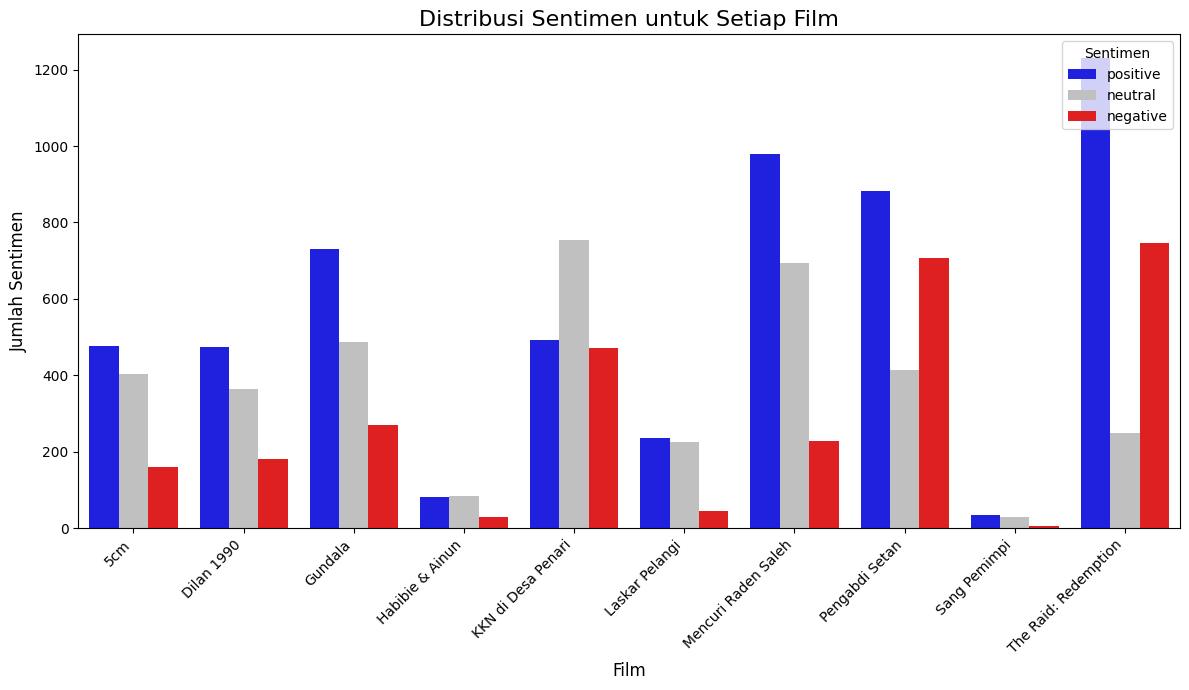

In [24]:
films = [
    'Laskar Pelangi', 'Sang Pemimpi', 'The Raid: Redemption', 'Habibie & Ainun',
    'Pengabdi Setan', 'Dilan 1990', '5cm', 'KKN di Desa Penari',
    'Gundala', 'Mencuri Raden Saleh'
]
filtered_df = df[df['film'].isin(films)]
sentiment_counts = filtered_df.groupby(['film', 'sentiment_label']).size().reset_index(name='count')

custom_palette = {
    'positive': 'blue',
    'negative': 'red',
    'neutral': 'silver'
}


hue_order = ['positive', 'neutral', 'negative']

plt.figure(figsize=(12, 7))
sns.barplot(
    data=sentiment_counts,
    x='film',
    y='count',
    hue='sentiment_label',
    palette=custom_palette,
    hue_order=hue_order
)
plt.title('Distribusi Sentimen untuk Setiap Film', fontsize=16)
plt.xlabel('Film', fontsize=12)
plt.ylabel('Jumlah Sentimen', fontsize=12)
plt.legend(title='Sentimen', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

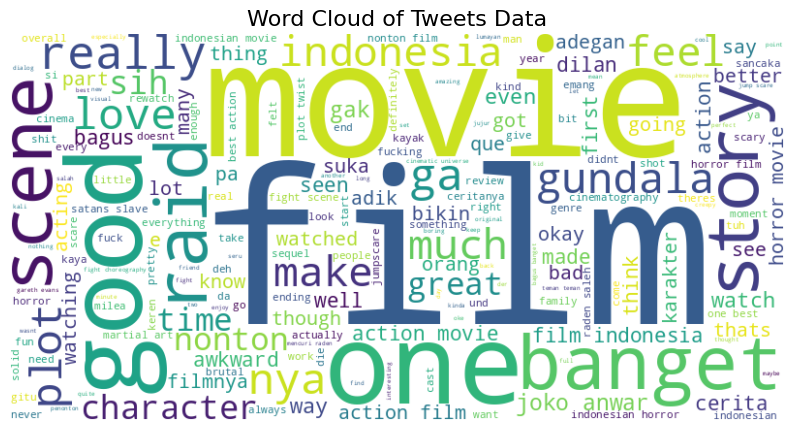

In [25]:
from wordcloud import WordCloud

all_text = ' '.join(df['text_akhir'].astype(str).tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', contour_color='black').generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets Data', fontsize=16)
plt.show()

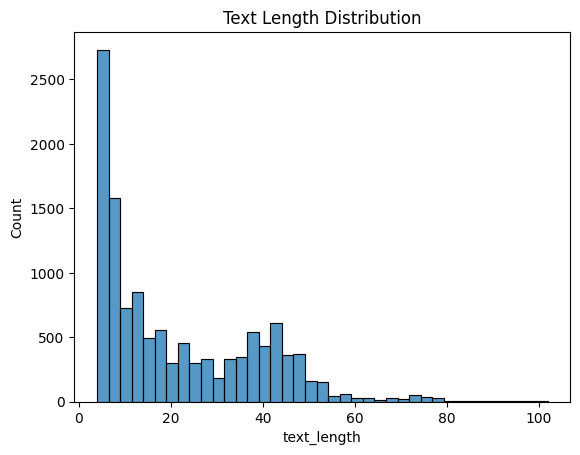

In [26]:
df['text_length'] = df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(df['text_length'])
plt.title('Text Length Distribution')
plt.show()

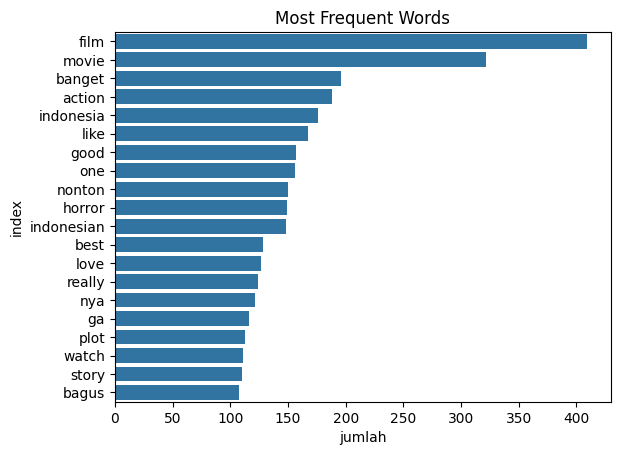

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

# Feature Extraction & Modelling


In [28]:
X = df['text_akhir']
y = df['sentiment_label']

# Feature Extraction


In [29]:
tfidf = TfidfVectorizer(max_features=7000, min_df=10, max_df=0.7, ngram_range=(1,1))
X_tfidf = tfidf.fit_transform(X)

# Modelling with ML Algorithm

using Logistic Regression

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score

clf = LogisticRegression(max_iter=1000, C=10, solver='saga', multi_class='multinomial')
clf.fit(X_train, y_train)

print("Test Accuracy before using GridSearchCV:", clf.score(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Accuracy before using GridSearchCV: 0.8105219893136046


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000, solver='saga', multi_class='multinomial'))
])

param_grid = {
    'tfidf__max_features': [3000, 5000, 7000],
    'tfidf__min_df': [5, 10, 15, 17],
    'tfidf__max_df': [0.7, 0.8],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.1, 1, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X, y)

print("Best parameters:")
print(grid_search.best_params_)

print("\nBest cross-validation accuracy:")
print(grid_search.best_score_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_pred = grid_search.best_estimator_.predict(X_test)

print("\nTest Accuracy after using GridSearchCV:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 144 candidates, totalling 432 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters:
{'clf__C': 10, 'tfidf__max_df': 0.7, 'tfidf__max_features': 3000, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}

Best cross-validation accuracy:
0.7502671598849157

Test Accuracy after using GridSearchCV: 0.9502671598849157

Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.90      0.92       559
     neutral       0.95      0.97      0.96       754
    positive       0.96      0.96      0.96      1120

    accuracy                           0.95      2433
   macro avg       0.95      0.94      0.95      2433
weighted avg       0.95      0.95      0.95      2433



# Modelling with Deep Learning Algorithm

using LSTM



In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

df['text_joined'] = df['text_tokenizingText'].apply(lambda x: ' '.join(x))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text_joined'])

sequences = tokenizer.texts_to_sequences(df['text_joined'])
X_padded = pad_sequences(sequences, maxlen=100)
vocab_size = len(tokenizer.word_index) + 1

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
if 'numeric_rating' not in df.columns:
    df['numeric_rating'] = df['rating'].apply(convert_rating)  # Assuming 'convert_rating' function is defined
    df['numeric_rating'] = df['numeric_rating'].fillna(df['numeric_rating'].median())

numeric_feature = scaler.fit_transform(df[['numeric_rating']])

In [34]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout, BatchNormalization

input_text = Input(shape=(100,))
embedding = Embedding(input_dim=vocab_size, output_dim=100, input_length=100)(input_text)
lstm_out = LSTM(128)(embedding)

input_numeric = Input(shape=(1,))

concat = Concatenate()([lstm_out, input_numeric])

dense = Dense(64, activation='relu')(concat)
output = Dense(3, activation='softmax')(dense)

model = Model(inputs=[input_text, input_numeric], outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 100)  │  3,966,600 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    117,248 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 129)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,320 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        195 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,092,363 (15.61 MB)

 Trainable params: 4,092,363 (15.61 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
from keras.utils import to_categorical

label_map = {'positive': 0, 'neutral': 1, 'negative': 2}
df['label_encoded'] = df['sentiment_label'].map(label_map)
y = to_categorical(df['label_encoded'])

X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_padded, numeric_feature, y, test_size=0.2, random_state=42
)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.90):
      print("\nAkurasi Validasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

model.fit([X_text_train, X_num_train], y_train, epochs=100, batch_size=64, validation_data=([X_text_test, X_num_test], y_test), callbacks = [callbacks])

Epoch 1/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5506 - loss: 0.9350 - val_accuracy: 0.6769 - val_loss: 0.7098
Epoch 2/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7924 - loss: 0.5218 - val_accuracy: 0.8023 - val_loss: 0.5872
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9439 - loss: 0.1822 - val_accuracy: 0.8015 - val_loss: 0.5892
Epoch 4/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9723 - loss: 0.0990 - val_accuracy: 0.7838 - val_loss: 0.7212
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9823 - loss: 0.0729 - val_accuracy: 0.7998 - val_loss: 0.7475
Epoch 6/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9858 - loss: 0.0524 - val_accuracy: 0.8007 - val_loss: 0.8393
Epoch 7/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9914 - loss: 0.0336 - val_accuracy: 0.8023 - val_loss: 0.9969
Epoch 8/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9932 - loss: 0.0259 - 

In [36]:
loss, accuracy = model.evaluate([X_text_test, X_num_test], y_test)
print(f"Akurasi Validasi: {accuracy:.2%}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7958 - loss: 3.3271
Akurasi Validasi: 78.96%


# Modelling with Pre-trained Model

using BERT



In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text_akhir'], df['label_encoded'], test_size=0.2, random_state=42
)

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_texts(texts, max_len=128):
    return tokenizer(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors='tf'
    )

train_encodings = encode_texts(X_train)
test_encodings = encode_texts(X_test)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [41]:
import tensorflow as tf

def create_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    )).batch(16)

train_dataset = create_dataset(train_encodings, y_train)
test_dataset = create_dataset(test_encodings, y_test)

In [42]:
from transformers import TFBertForSequenceClassification, create_optimizer
from tensorflow.keras.optimizers import Adam

model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3
)

num_train_steps = len(train_dataset) * 3
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps
)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(
    train_dataset,
    epochs=3,
    validation_data=test_dataset
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
609/609 [==============================] - 327s 468ms/step - loss: 0.5040 - accuracy: 0.8031 - val_loss: 0.3193 - val_accuracy: 0.8923
Epoch 2/3
609/609 [==============================] - 262s 430ms/step - loss: 0.2471 - accuracy: 0.9178 - val_loss: 0.2991 - val_accuracy: 0.9038
Epoch 3/3
609/609 [==============================] - 262s 430ms/step - loss: 0.1491 - accuracy: 0.9537 - val_loss: 0.3030 - val_accuracy: 0.9051


In [43]:
results = model.evaluate(test_dataset)
print(f"Akurasi: {results[1]:.2%}")

153/153 [==============================] - 22s 143ms/step - loss: 0.3030 - accuracy: 0.9051
Akurasi: 90.51%


# Prediction

In [51]:
sample_text = input('Masukkan teks (dalam Bahasa Indonesia atau Inggris): ')
inputs = tokenizer(sample_text, return_tensors='tf')
outputs = model(inputs)
predicted_class = tf.argmax(outputs.logits, axis=1).numpy()[0]

print(f"Prediksi: {list(label_map.keys())[predicted_class]}")

Masukkan teks (dalam Bahasa Indonesia atau Inggris): its a very good movie
Prediksi: positive
